In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# تحميل بيانات الأسهم
symbol = "AAPL"  # مثال على رمز سهم
data = yf.download(symbol, period="6mo", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [3]:
# حساب المؤشرات الفنية (SMA, EMA, RSI)
data['SMA'] = data['Close'].rolling(window=14).mean()  # المتوسط المتحرك البسيط
data['EMA'] = data['Close'].ewm(span=14, adjust=False).mean()  # المتوسط المتحرك الأسي

# إنشاء ميزة RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

In [ ]:
data

Price,Adj Close,Close,High,Low,Open,Volume,SMA,EMA,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,,
2024-06-07,196.446228,196.889999,196.940002,194.139999,194.649994,53103900,NaN,196.889999,NaN
2024-06-10,192.684723,193.119995,197.300003,192.149994,196.899994,97262100,NaN,196.387332,NaN
2024-06-11,206.683105,207.149994,207.160004,193.630005,193.649994,172373300,NaN,197.822354,NaN
2024-06-12,212.589783,213.070007,220.199997,206.899994,207.369995,198134300,NaN,199.855374,NaN
2024-06-13,213.757141,214.240005,216.750000,211.600006,214.740005,97862700,NaN,201.773325,NaN
...,...,...,...,...,...,...,...,...,...
2024-12-02,239.589996,239.589996,240.789993,237.160004,237.270004,48137100,230.431427,232.123627,83.362289
2024-12-03,242.649994,242.649994,242.759995,238.899994,239.809998,38861000,231.747141,233.527143,85.314411


In [4]:
# تحديد المدخلات (Features) والإخراجات (Target)
features = data[['Close', 'SMA', 'EMA', 'RSI']].dropna()  # استخدام البيانات التاريخية والمؤشرات
target = features['Close'].shift(-30)  # السعر المتوقع بعد 30 يومًا

In [11]:
features.head()

Price,Close,SMA,EMA,RSI
Ticker,AAPL,,,
Date,,,,
2024-06-27,214.100006,209.260715,208.863338,68.461710
2024-06-28,210.619995,210.241429,209.097559,63.705323
2024-07-01,216.750000,211.929286,210.117884,72.526215
2024-07-02,220.270004,212.866430,211.471500,65.641398
2024-07-03,221.550003,213.472144,212.815300,61.367286


In [12]:
target.head()

Ticker,AAPL
Date,
2024-06-27,216.240005
2024-06-28,217.529999
2024-07-01,221.270004
2024-07-02,221.720001
2024-07-03,224.720001


In [5]:
# إزالة القيم الفارغة في target (التي لا تحتوي على بيانات 30 يومًا)
features = features.iloc[:-30]
target = target.dropna()

In [6]:
# تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67, 4), (17, 4), (67, 1), (17, 1))

In [13]:
# تطبيق التوحيد (Normalization) على المدخلات
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# تحويل البيانات إلى الشكل الذي يناسب LSTM
X_train_scaled = np.array(X_train_scaled).reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.array(X_test_scaled).reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [15]:
# بناء النموذج (LSTM)
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(units=1))  # إخراج واحد وهو سعر السهم المتوقع

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\omar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 51233.2500
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51050.3906  
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51110.7422  
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 51055.7422
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51152.7734  
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51144.7930 
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 51291.5586  
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 51133.6758 
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 51292.4062 
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51139.57035
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 51086.1484
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 51066.5352 
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51192.2344 
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 51071.3633  
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

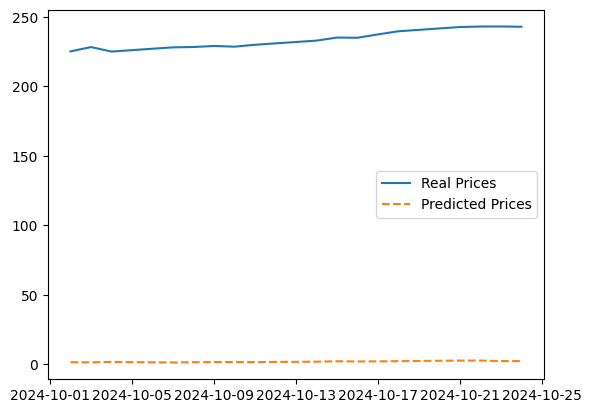

In [16]:
# تدريب النموذج
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32)

# التنبؤ
predictions = model.predict(X_test_scaled)

# عرض النتائج
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test.values, label='Real Prices')
plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
plt.legend()
plt.show()
